In [1]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import random
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
from tabulate import tabulate
from datasets import load_dataset
from collections import defaultdict
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, concatenate
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

c:\Users\deth_\miniconda3\envs\CNN\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Change lang here. I have collected all variables that are changed across different
# langs here for ease of changing but have left a commented out duplicate near where
# they were originally used to show context of what's being used in the code.
lang = 'pharo'  # IMPORTANT: Change this to see the notebook run for different languages
max_length = 30 # 26 python, 30 pharo, 35 java
learning_rate = 0.0025 # 0.0025 for all
batch_size = 48 # 60 for java, python, 48 for pharo
epochs = 10 # 10 python and pharo, 8 java

def lr_schedule(epoch, lr):
    if epoch < 5: # 5 for java, pharo, 2 for python
        return lr
    else:
        return lr * tf.math.exp(-0.33)
    
# Search for the phrase below and comment the line out for 'pharo' runs
# callbacks = [lr_scheduler]

In [4]:
langs = ['java', 'python', 'pharo']
labels = {
    'java': ['summary', 'Ownership', 'Expand', 'usage', 'Pointer', 'deprecation', 'rational'],
    'python': ['Usage', 'Parameters', 'DevelopmentNotes', 'Expand', 'Summary'],
    'pharo': ['Keyimplementationpoints', 'Example', 'Responsibilities', 'Classreferences', 'Intent', 'Keymessages', 'Collaborators']
}
ds = load_dataset('NLBSE/nlbse25-code-comment-classification')
ds

DatasetDict({
    java_train: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 7614
    })
    java_test: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 1725
    })
    python_train: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 1884
    })
    python_test: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 406
    })
    pharo_train: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 1298
    })
    pharo_test: Dataset({
        features: ['index', 'class', 'comment_sentence', 'partition', 'combo', 'labels'],
        num_rows: 289
    })
})

In [5]:
import requests
import zipfile

# This file is too big to upload directly to Github unfortunately
# so run this just once the first time you run the program to get
# it downloaded then comment this code out because it takes about
# 3 minutes for this to download and will attempt to redownload
# the file every time it's run.
response = requests.get("http://nlp.stanford.edu/data/glove.6B.zip", stream=True)
with open("glove.6B.zip", "wb") as f:
    for chunk in response.iter_content(chunk_size=2048):
        f.write(chunk)

with zipfile.ZipFile("glove.6B.zip", "r") as zip_path:
    zip_path.extractall("./glove")

In [6]:
# Using pretrained word embeddings courtesy of these folks below
# Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation

def load_glove(glove_path):
    embeddings_dict = {}
    with open(glove_path, encoding='utf8') as file:
        for dataline in file:
            splitLine = dataline.split()
            word = splitLine[0]
            vector = np.asarray(splitLine[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

embeddings_dict = load_glove('glove/glove.6B.100d.txt')

In [7]:
seed = 7359
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [8]:
def find_significant_words(data, labels, min_word_count=2, sig_words_threshold=0.15):
    label_counts_dict = {label: defaultdict(int) for label in labels}
    label_total_word_count = {label: 0 for label in labels}
    all_word_counts = defaultdict(int)
    total_words = 0 
    
    # Getting counts for all the words in the labels
    for comment, label_list in zip(data['comments'], data['labels']):
        words = comment.split()
        total_words += len(words)
        for word in words:
            all_word_counts[word] += 1
        for label, is_present in zip(labels, label_list):
            if is_present == 1:
                label_total_word_count[label] += len(words)
                for word in words:
                    label_counts_dict[label][word] += 1

    full_vocab = all_word_counts.keys()
    for label in labels: # This sections adds Laplace smoothing
        for word in full_vocab:
            label_counts_dict[label][word] += 1
        label_total_word_count[label] += len(full_vocab)

    significant_words_dict = {}
    index = 0
    for word in full_vocab:
        word_total_count = all_word_counts[word]
        if word_total_count < min_word_count: # Keep at least at 2
            continue # Don't want to add words that only have a 1 count due to Laplace smoothing
        
        for label in labels:
            word_count_in_label = label_counts_dict[label][word]
            word_count_not_in_label = 0
            for other_label in labels:
                if other_label != label:
                    word_count_not_in_label += label_counts_dict[other_label][word]
            total_words_not_in_label = 0
            for other_label in labels:
                if other_label != label:
                    total_words_not_in_label += label_total_word_count[other_label]

            # Uses log odds to determine if a label is more prominent
            # in one class versus all the others
            word_prob_in_label = word_count_in_label / label_total_word_count[label]
            word_prob_not_in_label = word_count_not_in_label / total_words_not_in_label
            log_odds = math.log(word_prob_in_label / word_prob_not_in_label)
            if abs(log_odds) >= sig_words_threshold:
                if word not in significant_words_dict:
                    significant_words_dict[word] = index
                    index += 1

    print("Number of significant words: ", len(significant_words_dict))
    return significant_words_dict

def tokenize_with_significant_words(comments, significant_words_dict):
    tokenized_comments = []
    for comment in comments:
        words = comment.split()
        tokenized = []
        for word in words:
            if word in significant_words_dict:
                tokenized.append(significant_words_dict[word])
        tokenized_comments.append(tokenized)
    return tokenized_comments

In [9]:
train_comments = [dataline['comment_sentence'] for dataline in ds[f'{lang}_train']]
test_comments = [dataline['comment_sentence'] for dataline in ds[f'{lang}_test']]

train_data = {
    'comments': train_comments,
    'labels': [dataline['labels'] for dataline in ds[f'{lang}_train']]
}

# Snippet of the now defunct Tokenizer we started with
# max_vocab_size = 3000
# max_length = 30
# tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
# tokenizer.fit_on_texts(train_comments)

significant_words_dict = find_significant_words(train_data, labels[lang], min_word_count=2, sig_words_threshold=0.15)
train_tokenized_comments = tokenize_with_significant_words(train_comments, significant_words_dict)
test_tokenized_comments = tokenize_with_significant_words(test_comments, significant_words_dict)
train_lengths = [len(seq) for seq in train_tokenized_comments]
test_lengths = [len(seq) for seq in test_tokenized_comments]

train_mean = np.mean(train_lengths)
train_median = np.median(train_lengths)
train_max = np.max(train_lengths)
train_q1 = np.percentile(train_lengths, 25)
train_q3 = np.percentile(train_lengths, 75)

test_mean = np.mean(test_lengths)
test_median = np.median(test_lengths)
test_max = np.max(test_lengths)
test_q1 = np.percentile(test_lengths, 25)
test_q3 = np.percentile(test_lengths, 75)

print("\nTrain Sequences:")
print(f"Average Length = {train_mean:.2f}")
print("1st Quartile   =", train_q1)
print("Median Length  =", train_median)
print("3rd Quartile   =", train_q3)
print("Max Length     =", train_max)

print("\nTest Sequences:")
print(f"Average Length = {test_mean:.2f}")
print("1st Quartile   =", test_q1)
print("Median Length  =", test_median)
print("3rd Quartile   =", test_q3)
print("Max Length     =", test_max)

# Have moved a duplicate of this line to the top of the notebook for the sake
# of easily switching between the hyperparameters that worked for different langs.
# Keep this here to show context of where it's used.
# max_length = 35 # 26 python, 30 pharo, 35 java
train_with_padding = pad_sequences(train_tokenized_comments, maxlen=max_length, padding='post', truncating='post')
test_with_padding = pad_sequences(test_tokenized_comments, maxlen=max_length, padding='post', truncating='post')

train_labels = np.array([dataline['labels'] for dataline in ds[f'{lang}_train']])
test_labels = np.array([dataline['labels'] for dataline in ds[f'{lang}_test']])

Number of significant words:  1225

Train Sequences:
Average Length = 7.73
1st Quartile   = 3.0
Median Length  = 6.0
3rd Quartile   = 11.0
Max Length     = 40

Test Sequences:
Average Length = 6.25
1st Quartile   = 2.0
Median Length  = 5.0
3rd Quartile   = 9.0
Max Length     = 27


In [10]:
def make_sig_word_weights(significant_words_dict, embeddings_dict, embedding_dim):
    vocab_len = len(significant_words_dict) + 1
    sig_word_weights = np.random.normal(scale=0.6, size=(vocab_len, embedding_dim))
    words_not_in_glove = 0
    for word, index in significant_words_dict.items():
        embedding_vector = embeddings_dict.get(word)
        # print(embedding_vector) # To get an idea of what scale above should be
        if embedding_vector is not None:
            sig_word_weights[index] = embedding_vector
        else:
            words_not_in_glove += 1
    print(f"Percent of words not in Glove vocab: {((words_not_in_glove/len(significant_words_dict)) * 100):.2f}%")
    return sig_word_weights

embedding_dim = 100  # Glove 100d
sig_word_weights = make_sig_word_weights(significant_words_dict, embeddings_dict, embedding_dim)


Percent of words not in Glove vocab: 22.53%


In [11]:
# # Attempts to use stratify with this for more than binary labels blows this function up
# from sklearn.model_selection import train_test_split

# train_with_padding, val_with_padding, train_labels, val_labels = train_test_split(
#     train_with_padding, train_labels, test_size=0.2, random_state=seed)

In [12]:
multisplit = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=seed)
for train_index, val_index in multisplit.split(train_with_padding, train_labels):
    train_with_padding, val_with_padding = train_with_padding[train_index], train_with_padding[val_index]
    train_labels, val_labels = train_labels[train_index], train_labels[val_index]

In [13]:
labels_list = labels[lang]
num_labels = len(labels_list)
vocab_len = len(significant_words_dict) + 1
num_filters = 128
filter_sizes = [2, 3, 4]

inputs = Input(shape=(max_length,))
embedding = Embedding(
    input_dim = vocab_len,
    output_dim = embedding_dim,
    weights = [sig_word_weights],
    input_length = max_length,
    trainable = True,
)(inputs)

cnn_dif_filter_outputs = []
for size in filter_sizes:
    cnn_filter = Conv1D(filters=num_filters, kernel_size=size, activation='relu', padding='same')(embedding)
    max_pool = MaxPooling1D(pool_size=2)(cnn_filter)
    cnn_dif_filter_outputs.append(max_pool)
cnn_combined_output = concatenate(cnn_dif_filter_outputs)

lstm_layer = Bidirectional(LSTM(units = 64, return_sequences=True))(cnn_combined_output)
global_pool = GlobalMaxPooling1D()(lstm_layer)
dense_layer = Dense(units=64, activation=None)(global_pool) # relu also good results, sigmoid subpar
dropout_layer = Dropout(rate= 0.5)(dense_layer) # .55 also typically works fine
output_layer = Dense(num_labels, activation='sigmoid')(dropout_layer) # relu bad here
model = tf.keras.Model(inputs=inputs, outputs=output_layer)
model.summary()

# Have moved a duplicate of this line to the top of the notebook for the sake
# of easily switching between the hyperparameters that worked for different langs.
# Keep this here to show context of where it's used.
# learning_rate = 0.0025 # 0.0025 for java, python, 0.001 for pharo
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer, # originally just default 'adam' parameter
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      122600      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 30, 128)      25728       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 30, 128)      38528       ['embedding[0][0]']              
                                                                                              

In [14]:
# Have moved a duplicate of this line to the top of the notebook for the sake
# of easily switching between the hyperparameters that worked for different langs.
# Keep this here to show context of where it's used.
# epochs = 10 # 10 python and pharo, 8 java
# batch_size = 60 # 60 for java, python, 48 for pharo

label_counts = np.sum(train_labels, axis=0)
total_counts = np.sum(label_counts)
label_percentages = label_counts / total_counts
label_inv_freqs = (1 / label_percentages)
sample_weights = np.sum(train_labels * label_inv_freqs, axis=1)

# Some code below used to get an idea of the spread of values we were working with.
# highest = 0
# for weight in sample_weights.tolist():
#     print(f"{weight:.2f}")
#     if weight > highest:
#         highest = weight
# print('HIGHEST VALUE:', highest) # Highest val: 19.29
# sample_weights = sample_weights / np.mean(sample_weights)
# Above: weights were performing better when not normalized

# plt.hist(sample_weights, bins=10)
# plt.title("Distribution of Sample Weights")
# plt.show()

# Also at top of notebook
# def lr_schedule(epoch, lr):
#     if epoch < 5: # 5 for java, pharo, 2 for python
#         return lr
#     else:
#         return lr * tf.math.exp(-0.33)
    
lr_scheduler = LearningRateScheduler(lr_schedule)    

history = model.fit(
    train_with_padding,
    train_labels,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (val_with_padding, val_labels),
    callbacks = [lr_scheduler], # disabled for pharo, 
    # sample_weight = sample_weights, # disabled for all models, just not helpful
    verbose = 1
)

Epoch 1/10
22/22 [==============================] - 4s 59ms/step - loss: 0.4320 - precision: 0.4448 - recall: 0.2215 - auc: 0.6855 - val_loss: 0.3488 - val_precision: 0.7228 - val_recall: 0.2500 - val_auc: 0.8071 - lr: 0.0025
Epoch 2/10
22/22 [==============================] - 1s 31ms/step - loss: 0.3497 - precision: 0.6365 - recall: 0.3322 - auc: 0.7977 - val_loss: 0.3080 - val_precision: 0.7794 - val_recall: 0.3630 - val_auc: 0.8570 - lr: 0.0025
Epoch 3/10
22/22 [==============================] - 1s 31ms/step - loss: 0.3062 - precision: 0.6998 - recall: 0.3863 - auc: 0.8526 - val_loss: 0.2888 - val_precision: 0.8102 - val_recall: 0.3801 - val_auc: 0.8745 - lr: 0.0025
Epoch 4/10
22/22 [==============================] - 1s 31ms/step - loss: 0.2633 - precision: 0.7577 - recall: 0.5099 - auc: 0.8944 - val_loss: 0.2751 - val_precision: 0.7474 - val_recall: 0.4863 - val_auc: 0.8896 - lr: 0.0025
Epoch 5/10
22/22 [==============================] - 1s 31ms/step - loss: 0.2300 - precision: 0.7

In [15]:
# Transitioned away from this to a more dynamic threshold below
# test_probabilities = model.predict(test_with_padding)
# test_predictions = (test_probabilities > 0.5).astype(int)
# print(classification_report(test_labels, test_predictions, target_names=labels_list))

In [16]:
val_probabilities = model.predict(val_with_padding)
best_threshold = 0
best_total_f1 = 0

for threshold in (start / 400 for start in range(401)): # Search by 0.0025 steps
    val_predictions = (val_probabilities >= threshold).astype(int)
    total_f1 = 0
    for label_index in range(train_labels.shape[1]):
        f1 = f1_score(val_labels[:, label_index], val_predictions[:, label_index])
        total_f1 += f1

    if total_f1 > best_total_f1:
        best_total_f1 = total_f1
        best_threshold = threshold

print(f"Best Val Threshold: {best_threshold:.2f}")

test_probabilities = model.predict(test_with_padding)
test_predictions = (test_probabilities >= best_threshold).astype(int)
print(classification_report(test_labels, test_predictions, target_names=labels_list))


9/9 [==============================] - 1s 9ms/step
Best Val Threshold: 0.23
10/10 [==============================] - 0s 10ms/step
                         precision    recall  f1-score   support

Keyimplementationpoints       0.42      0.35      0.38        43
                Example       0.69      0.95      0.80       119
       Responsibilities       0.48      0.58      0.53        52
        Classreferences       0.00      0.00      0.00         4
                 Intent       0.70      0.87      0.78        30
            Keymessages       0.38      0.53      0.45        43
          Collaborators       0.12      0.20      0.15        10

              micro avg       0.55      0.69      0.62       301
              macro avg       0.40      0.50      0.44       301
           weighted avg       0.54      0.69      0.61       301
            samples avg       0.62      0.70      0.64       301



c:\Users\deth_\miniconda3\envs\CNN\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


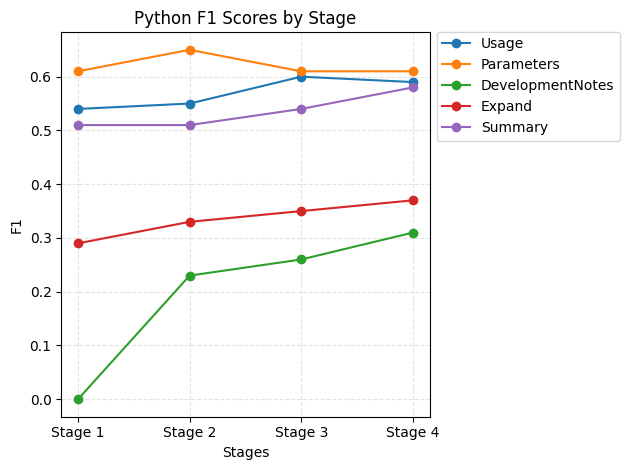

In [68]:
stages = ["Stage 1", "Stage 2", "Stage 3", "Stage 4"] # Stage 1 = our baseline
data = [
    ["Usage", 0.54, 0.55, 0.60, 0.59],
    ["Parameters", 0.61, 0.65, 0.61, 0.61],
    ["DevelopmentNotes", 0.00, 0.23, 0.26, 0.31],
    ["Expand", 0.29, 0.33, 0.35, 0.37],
    ["Summary", 0.51, 0.51, 0.54, 0.58],
]

for row in data:
    label = row[0]
    scores = row[1:]
    plt.plot(stages, scores, marker='o', label=label)

plt.title("Python F1 Scores by Stage")
plt.xlabel("Stages")
plt.ylabel("F1")
plt.grid(True, linestyle='--', alpha=0.35)
plt.legend(loc='center left', bbox_to_anchor=(1, .86))
plt.tight_layout()
plt.show()

In [69]:
tableData = []
totalStage1 = 0
totalStage4 = 0
headers = ["Label", "Stage 1", "Stage 4", "Raw % Change", "Comparative % Change"]

for row in data:
    label = row[0]
    scores = row[1:]
    stage1 = scores[0]
    stage4 = scores[-1]
    increase = stage4 - stage1
    percentageIncrease = 0
    if stage1 > 0:
        percentageIncrease = (stage4 / stage1 - 1) * 100
    else:
        percentageIncrease = "N/A"
    totalStage1 += stage1
    totalStage4 += stage4
    if percentageIncrease != "N/A":
        tableData.append([label, f"{stage1:.2f}", f"{stage4:.2f}", f"{increase:.2f}", f"{percentageIncrease:.2f}"])
    else:
        tableData.append([label, f"{stage1:.2f}", f"{stage4:.2f}", f"{increase:.2f}", percentageIncrease])

totalIncrease = totalStage4 - totalStage1
if totalStage1 > 0:
    totalPercentageIncrease = (totalStage4 / totalStage1 - 1) * 100
else:
    totalPercentageIncrease = "N/A"
if totalPercentageIncrease != "N/A":
    tableData.append(["Cumulative", f"{totalStage1:.2f}", f"{totalStage4:.2f}", f"{totalIncrease:.2f}", f"{totalPercentageIncrease:.2f}"])
else:
    tableData.append(["Cumulative", f"{totalStage1:.2f}", f"{totalStage4:.2f}", f"{totalIncrease:.2f}", totalPercentageIncrease])

print("Python table:")
print(tabulate(tableData, headers=headers, tablefmt="fancy_grid"))

╒══════════════════╤═══════════╤═══════════╤════════════════╤════════════════════════╕
│ Label            │   Stage 1 │   Stage 4 │   Raw % Change │ Comparative % Change   │
╞══════════════════╪═══════════╪═══════════╪════════════════╪════════════════════════╡
│ Usage            │      0.54 │      0.59 │           0.05 │ 9.26                   │
├──────────────────┼───────────┼───────────┼────────────────┼────────────────────────┤
│ Parameters       │      0.61 │      0.61 │           0    │ 0.00                   │
├──────────────────┼───────────┼───────────┼────────────────┼────────────────────────┤
│ DevelopmentNotes │      0    │      0.31 │           0.31 │ N/A                    │
├──────────────────┼───────────┼───────────┼────────────────┼────────────────────────┤
│ Expand           │      0.29 │      0.37 │           0.08 │ 27.59                  │
├──────────────────┼───────────┼───────────┼────────────────┼────────────────────────┤
│ Summary          │      0.51 │      0.58 

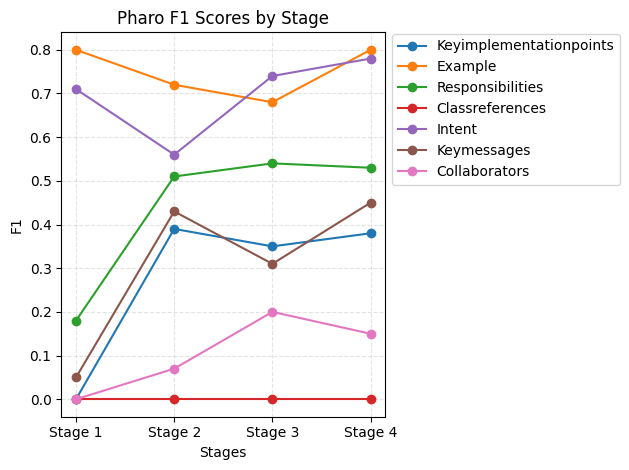

In [70]:
data = [
    ["Keyimplementationpoints", 0.00, 0.39, 0.35, 0.38],
    ["Example", 0.80, 0.72, 0.68, 0.80],
    ["Responsibilities", 0.18, 0.51, 0.54, 0.53],
    ["Classreferences", 0.00, 0.00, 0.00, 0.00],
    ["Intent", 0.71, 0.56, 0.74, 0.78],
    ["Keymessages", 0.05, 0.43, 0.31, 0.45],
    ["Collaborators", 0.00, 0.07, 0.20, 0.15],
]

for row in data:
    label = row[0]
    scores = row[1:]
    plt.plot(stages, scores, marker='o', label=label)

plt.title("Pharo F1 Scores by Stage")
plt.xlabel("Stages")
plt.ylabel("F1")
plt.grid(True, linestyle='--', alpha=0.35)
plt.legend(loc='center left', bbox_to_anchor=(1, .8))
plt.tight_layout()
plt.show()

In [71]:
tableData = []
totalStage1 = 0
totalStage4 = 0
headers = ["Label", "Stage 1", "Stage 4", "Raw % Change", "Comparative % Change"]

for row in data:
    label = row[0]
    scores = row[1:]
    stage1 = scores[0]
    stage4 = scores[-1]
    increase = stage4 - stage1
    percentageIncrease = 0
    if stage1 > 0:
        percentageIncrease = (stage4 / stage1 - 1) * 100
    else:
        percentageIncrease = "N/A"
    totalStage1 += stage1
    totalStage4 += stage4
    if percentageIncrease != "N/A":
        tableData.append([label, f"{stage1:.2f}", f"{stage4:.2f}", f"{increase:.2f}", f"{percentageIncrease:.2f}"])
    else:
        tableData.append([label, f"{stage1:.2f}", f"{stage4:.2f}", f"{increase:.2f}", percentageIncrease])

totalIncrease = totalStage4 - totalStage1
if totalStage1 > 0:
    totalPercentageIncrease = (totalStage4 / totalStage1 - 1) * 100
else:
    totalPercentageIncrease = "N/A"
if totalPercentageIncrease != "N/A":
    tableData.append(["Cumulative", f"{totalStage1:.2f}", f"{totalStage4:.2f}", f"{totalIncrease:.2f}", f"{totalPercentageIncrease:.2f}"])
else:
    tableData.append(["Cumulative", f"{totalStage1:.2f}", f"{totalStage4:.2f}", f"{totalIncrease:.2f}", totalPercentageIncrease])

print("Pharo table:")
print(tabulate(tableData, headers=headers, tablefmt="fancy_grid"))

╒═════════════════════════╤═══════════╤═══════════╤════════════════╤════════════════════════╕
│ Label                   │   Stage 1 │   Stage 4 │   Raw % Change │ Comparative % Change   │
╞═════════════════════════╪═══════════╪═══════════╪════════════════╪════════════════════════╡
│ Keyimplementationpoints │      0    │      0.38 │           0.38 │ N/A                    │
├─────────────────────────┼───────────┼───────────┼────────────────┼────────────────────────┤
│ Example                 │      0.8  │      0.8  │           0    │ 0.00                   │
├─────────────────────────┼───────────┼───────────┼────────────────┼────────────────────────┤
│ Responsibilities        │      0.18 │      0.53 │           0.35 │ 194.44                 │
├─────────────────────────┼───────────┼───────────┼────────────────┼────────────────────────┤
│ Classreferences         │      0    │      0    │           0    │ N/A                    │
├─────────────────────────┼───────────┼───────────┼─────────

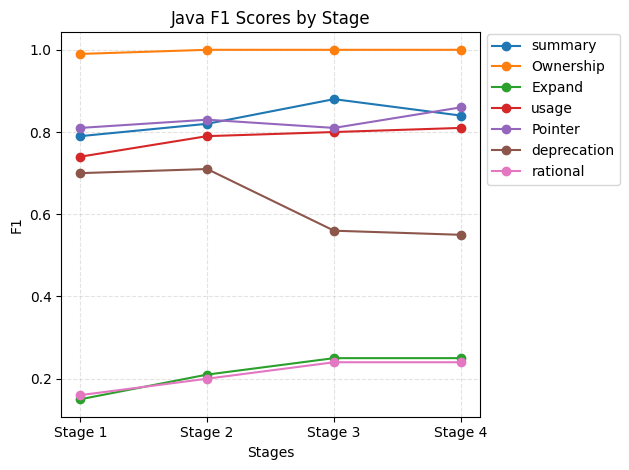

In [72]:
data = [
    ["summary", 0.79, 0.82, 0.88, 0.84],
    ["Ownership", 0.99, 1.00, 1.00, 1.00],
    ["Expand", 0.15, 0.21, 0.25, 0.25],
    ["usage", 0.74, 0.79, 0.80, 0.81],
    ["Pointer", 0.81, 0.83, 0.81, 0.86],
    ["deprecation", 0.70, 0.71, 0.56, 0.55],
    ["rational", 0.16, 0.20, 0.24, 0.24],
]

for row in data:
    label = row[0]
    scores = row[1:]
    plt.plot(stages, scores, marker='o', label=label)

plt.title("Java F1 Scores by Stage")
plt.xlabel("Stages")
plt.ylabel("F1")
plt.grid(True, linestyle='--', alpha=0.35)
plt.legend(loc='center left', bbox_to_anchor=(1, .8))
plt.tight_layout()
plt.show()

In [74]:
tableData = []
totalStage1 = 0
totalStage4 = 0
headers = ["Label", "Stage 1", "Stage 4", "Raw % Change", "Comparative % Change"]

for row in data:
    label = row[0]
    scores = row[1:]
    stage1 = scores[0]
    stage4 = scores[-1]
    increase = stage4 - stage1
    percentageIncrease = 0
    if stage1 > 0:
        percentageIncrease = (stage4 / stage1 - 1) * 100
    else:
        percentageIncrease = "N/A"
    totalStage1 += stage1
    totalStage4 += stage4
    if percentageIncrease != "N/A":
        tableData.append([label, f"{stage1:.2f}", f"{stage4:.2f}", f"{increase:.2f}", f"{percentageIncrease:.2f}"])
    else:
        tableData.append([label, f"{stage1:.2f}", f"{stage4:.2f}", f"{increase:.2f}", percentageIncrease])

totalIncrease = totalStage4 - totalStage1
if totalStage1 > 0:
    totalPercentageIncrease = (totalStage4 / totalStage1 - 1) * 100
else:
    totalPercentageIncrease = "N/A"
if totalPercentageIncrease != "N/A":
    tableData.append(["Cumulative", f"{totalStage1:.2f}", f"{totalStage4:.2f}", f"{totalIncrease:.2f}", f"{totalPercentageIncrease:.2f}"])
else:
    tableData.append(["Cumulative", f"{totalStage1:.2f}", f"{totalStage4:.2f}", f"{totalIncrease:.2f}", totalPercentageIncrease])

print("Java table:")
print(tabulate(tableData, headers=headers, tablefmt="fancy_grid"))

Java table:
╒═════════════╤═══════════╤═══════════╤════════════════╤════════════════════════╕
│ Label       │   Stage 1 │   Stage 4 │   Raw % Change │   Comparative % Change │
╞═════════════╪═══════════╪═══════════╪════════════════╪════════════════════════╡
│ summary     │      0.79 │      0.84 │           0.05 │                   6.33 │
├─────────────┼───────────┼───────────┼────────────────┼────────────────────────┤
│ Ownership   │      0.99 │      1    │           0.01 │                   1.01 │
├─────────────┼───────────┼───────────┼────────────────┼────────────────────────┤
│ Expand      │      0.15 │      0.25 │           0.1  │                  66.67 │
├─────────────┼───────────┼───────────┼────────────────┼────────────────────────┤
│ usage       │      0.74 │      0.81 │           0.07 │                   9.46 │
├─────────────┼───────────┼───────────┼────────────────┼────────────────────────┤
│ Pointer     │      0.81 │      0.86 │           0.05 │                   6.17 │
├───